# Introduction

In this notebook, we explore a [synthetic dataset that was uploaded to kaggle](https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression/data). This dataset provides a series of metrics about student study habits, participation in extracurricular activities, and test scores. We will break down the data and attempt to predict test scores based on study habits, then generate counterfactuals to indicate how a given student's study habits could be optimized.

Thanks to [Nikhil Narayan](https://www.kaggle.com/nikhil7280) for creating a fun dataset to play with.

This notebook is hosted in its own [Github repo](https://github.com/JoshuaRinaldo/student_performance_counterfactuals).

Install the required libraries if you want to run this notebook.

In [1]:
# !pip install dice-ml --quiet
# !pip install shap --quiet
# !pip install xgboost --quiet
# !pip install scikit-learn --quiet
# !pip install tensorflow==2.8.0

# numpy and pandas may need to be first manually uninstalled, then reinstalled
# !pip install numpy==1.26.4
# !pip install pandas==1.5.3
# !pip install seaborn

# Import Libraries

In [2]:
# Plotting libraries
import seaborn as sns
from pylab import rcParams

# DiCE counterfactuals
import dice_ml
from dice_ml import Dice

# DS/Machine learning libraries
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# We will test a Linear and Random Forest Regressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [3]:
data = pd.read_csv("Student_Performance.csv")

# Analyze Data

Before we train the model, let's take a better look at it. We will plot histograms of some selected features and check the correlation matrix. This will help us understand what transformations the data might need.

In [4]:
data.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [5]:
rcParams['figure.figsize'] = 12, 6

Text(0.5, 1.0, 'Previous Scores Distribution')

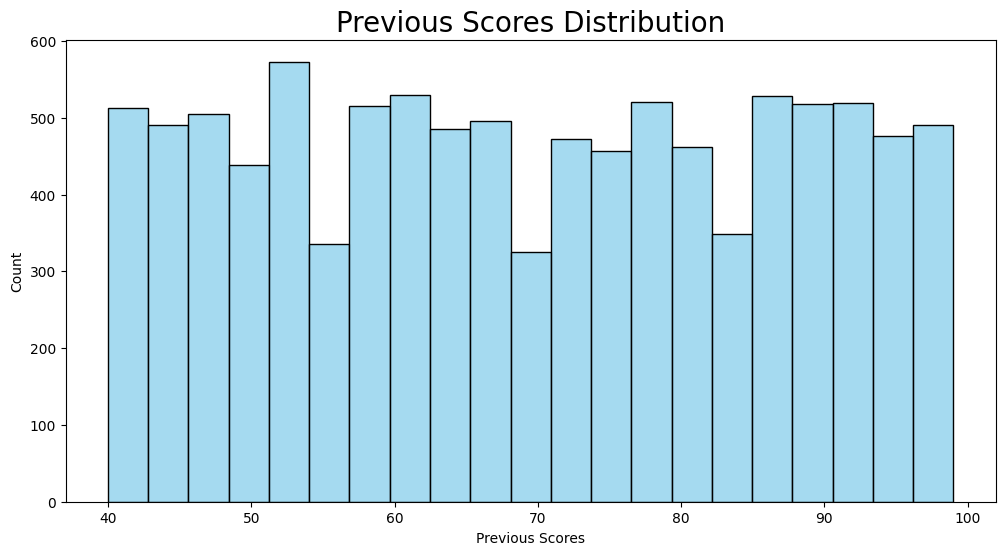

In [6]:
ax = sns.histplot(
    data,
    x="Previous Scores",
    color="skyblue",
)
ax.set_title(
    'Previous Scores Distribution',
    fontsize=20
)

Text(0.5, 1.0, 'Sleep Hours')

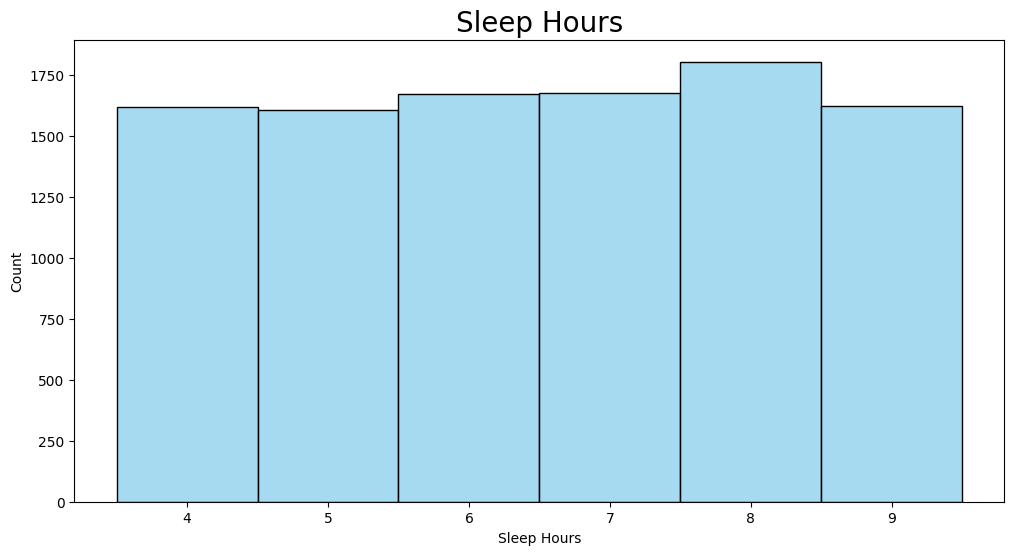

In [7]:
ax = sns.histplot(
    data,
    x="Sleep Hours",
    color="skyblue",
    discrete=True
)
ax.set_title(
    'Sleep Hours',
    fontsize=20
)

Text(0.5, 1.0, 'Hours Studied')

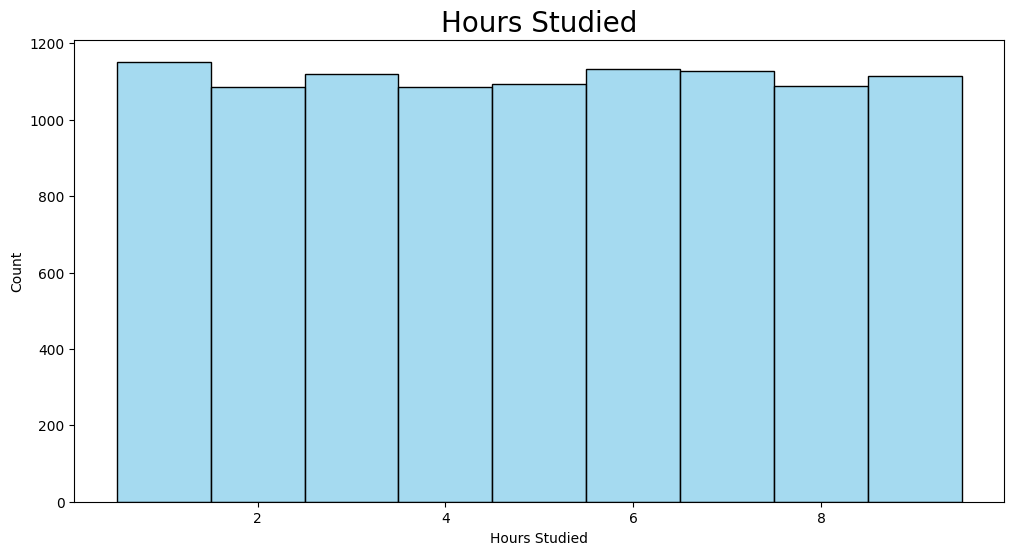

In [8]:
ax = sns.histplot(
    data,
    x="Hours Studied",
    color="skyblue",
    discrete=True
)
ax.set_title(
    'Hours Studied',
    fontsize=20
)

Text(0.5, 1.0, 'Sample Question Papers Practiced')

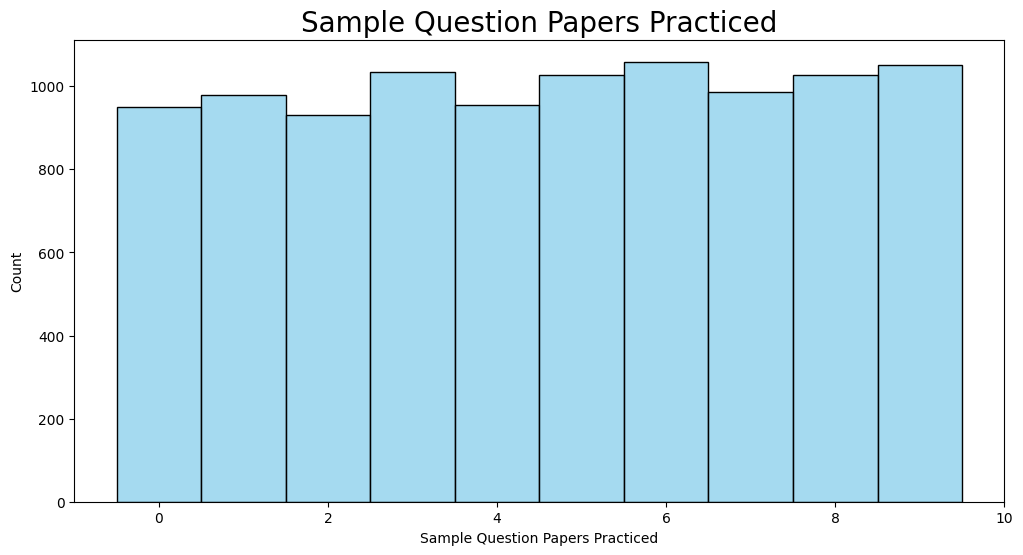

In [9]:
ax = sns.histplot(
    data,
    x="Sample Question Papers Practiced",
    color="skyblue",
    discrete=True
)
ax.set_title(
    'Sample Question Papers Practiced',
    fontsize=20
)

/tmp/ipykernel_27044/1916234901.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr().applymap(round, ndigits=3)


Text(0.5, 1.0, 'Correlation Matrix')

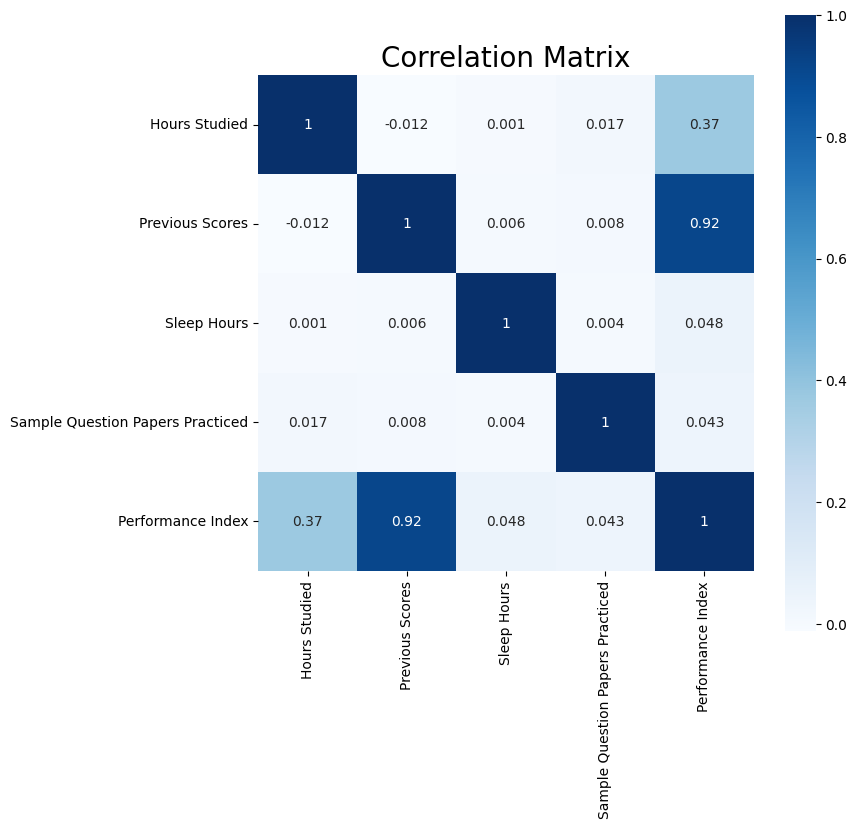

In [10]:
rcParams['figure.figsize'] = 8, 8

correlation_matrix = data.corr().applymap(round, ndigits=3)
ax = sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="Blues",
    square=True,
)

ax.set_title(
    "Correlation Matrix",
    fontsize=20
)

As we can see in the correlation matrix, the previous scores are strongly correlated to the performance index. There is a saying, "don't try to be better than others, try to be better than you were yesterday". I think in the context of education, this mindset is especially important.

If we train the model to predict the performance index, we will think the model is highly accurate because it can simply guess that a student will do roughly as well as they did last time. Instead, the target should be how much better did they do <i>compared</i> to their previous score. This should allow us to more truthfully assess the impact of a student's study habits.

Unfortunately, "previous score" looks like a typical X/100 one would see for a grade, but performance index is some composite score that doesn't map on to the "previous score" feature. To get a better understanding of the % increase a student might see from studying, we will normalize both columns, then set our target $T$ as $$T=\frac{\text{performance index}}{\text{previous score}}$$

We will also drop the "Previous Scores" and "Performance Index" before training.

# Transform Data

In [11]:
data["Performance Index"] = data["Performance Index"]/max(data["Performance Index"])

# Remove zeros from previous scores by rounding up to 1
# There are no zeroes in Previous Scores (for now), but it is wise to watch out for zero division!
data["Previous Scores"] = data["Previous Scores"].apply(max, args=([1]))
data["Previous Scores"] = data["Previous Scores"]/max(data["Previous Scores"])

data["Target"] = data["Performance Index"]/data["Previous Scores"]

In [12]:
data.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index,Target
0,7,1.000000,Yes,9,1,0.91,0.910000
1,4,0.828283,No,4,2,0.65,0.784756
2,8,0.515152,Yes,7,2,0.45,0.873529
3,5,0.525253,Yes,5,2,0.36,0.685385
4,7,0.757576,No,8,5,0.66,0.871200


In [13]:
data = data.drop(columns = ["Previous Scores", "Performance Index"])

# encode extracurricular activities
encoder = LabelEncoder()
data["Extracurricular Activities"] =  encoder.fit_transform(data["Extracurricular Activities"])

In [14]:
# we will save the transformed data because we will use it later in a docker image
data.to_csv("Transformed_Student_Performance.csv", index = False)

# Train models

In [15]:
# Drop target column
train = data.drop(columns = "Target")
target = data["Target"]

# Split and train model
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size = 0.2)

In [16]:
model_linear = LinearRegression()
model_linear.fit(x_train,y_train)

LinearRegression()

In [17]:
print(
    f"coefficient of determination: {model_linear.score(x_test, y_test)}\n",
    f"mean_absolute_error {mean_absolute_error(model_linear.predict(x_test), y_test)}"
)

coefficient of determination: 0.6713701713347007
 mean_absolute_error 0.06075247518369547


In [18]:
model_forest = RandomForestRegressor()
model_forest.fit(x_train,y_train)

RandomForestRegressor()

In [19]:
print(
    f"coefficient of determination: {model_forest.score(x_test, y_test)}\n",
    f"mean_absolute_error {mean_absolute_error(model_forest.predict(x_test), y_test)}"
)

coefficient of determination: 0.6137728421838562
 mean_absolute_error 0.06454191341441974


We see that the linear regressor is slightly more accurate than a random forest.

Usually we want a better coefficient of determination, but given the nature of the data, ~0.6 is not bad! We've removed any knowledge of a student's previous performance, and instead are predicting solely on study habits, sleep, and extracurriculars. However, we should be careful with our counterfactuals. If there is enough error, we may end up recommending behaviours that are unproductive (like suggesting a student get less sleep!).

In [20]:
predict = model_linear.predict(x_test)
performance_df = pd.DataFrame({"Actual Performance" : y_test, "Predicted Performance" : predict})

In [21]:
performance_df["Difference"] = abs(performance_df["Actual Performance"] - performance_df["Predicted Performance"])

Text(0.5, 1.0, 'Actual vs Predicted Performance')

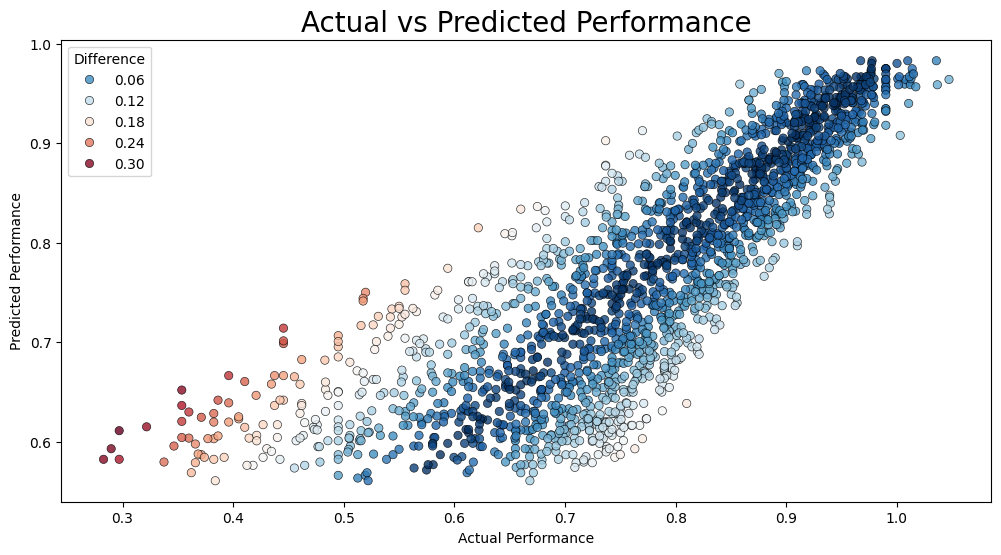

In [22]:
rcParams['figure.figsize'] = 12, 6

ax = sns.scatterplot(
    performance_df,
    x="Actual Performance",
    y="Predicted Performance",
    hue="Difference",
    palette="RdBu_r",
    edgecolor="k",
    alpha=0.8,
)

ax.set_title(
    "Actual vs Predicted Performance",
    fontsize=20
)

We can see that students who have better performance tend to have less error on the predictions. The model tends to score low-performing generously, giving higher predicted performance than reality. This looks like a case where the model is predicting higher scores because the scores in the training data tend to be high.

However, based on the plot shown above, there is clearly some learning going on. For the purposes of this notebook, I am satified with our model. In a scenario where we would use this to actually advise students, we would want to develop this model with much more rigour.

# Counterfactuals

How can we use this model to optimize study habits?

Since we have trained a model that predicts perfomance, we can use counterfactuals to see how tweaking study habits can cause the model to increase the predicted performance. We will take an input, predict the performance of that student, then generate counterfactuals where the study habits results in an X% increase in predicted performance.

In [23]:
continuous_features = [
    'Hours Studied',
    'Sleep Hours',
    'Sample Question Papers Practiced',
    'Extracurricular Activities',
  ]
target_name = "Target"

In [24]:
d = dice_ml.Data(dataframe=data, continuous_features=continuous_features, outcome_name=target_name)
m = dice_ml.Model(model=model_linear, backend="sklearn", model_type='regressor')

In [25]:
# Choosing random method because genetic can result in errors
exp = Dice(d, m, method="random")

In [26]:
# Multiple queries can be given as input at once
query_instances = x_test[1:2]
predicted_performance = float(model_linear.predict(query_instances))

/tmp/ipykernel_27044/3509291326.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_performance = float(model_linear.predict(query_instances))


In [27]:
# Choose a reasonable goal, expressed as a % increase from the predicted performance
lower_bound = predicted_performance*1.1
upper_bound = max(predicted_performance*1.4, 100)

In [28]:
predicted_performance

0.6571702167642575

In [29]:
genetic = exp.generate_counterfactuals(
    query_instances,
    total_CFs=3,
    desired_range=[lower_bound, upper_bound],
    features_to_vary=[
        'Hours Studied',
        'Sleep Hours',
        'Sample Question Papers Practiced',
    ]
)
genetic.visualize_as_dataframe(show_only_changes=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]

Query instance (original outcome : 1.0)


,Hours Studied,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Target
0,2,1,8,4,1.0



Diverse Counterfactual set (new outcome: [0.7228872384406833, 100])


,Hours Studied,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Target
0,9.0,-,4.0,-,0.929439127445221
1,4.0,-,-,9.0,0.7576147317886353
2,9.0,-,-,1.0,0.9534993767738342


And now we can generate counterfactuals!

Now that we have created the model and tested it out in the notebook, we will save the model.

# Save The Model

We will save the model in case we want to use it again.

...even though it is a simple linear regression model.

In [30]:
import pickle

pickle.dump(model_linear , open("student_performance_regressor.pk1" , "wb"))

In [31]:
new_model = pickle.load(open("student_performance_regressor.pk1", "rb"))

In [32]:
# Let's make sure that worked
new_model.predict(query_instances) == model_linear.predict(query_instances)

array([ True])

# Conclusion

Overall, this was a fun exercise, and serves as a proof-of-concept for a model trained on real data.

What we would learn from a good predictive models generating counterfactuals is probably already be conventional wisdom (e.g. studying more will increase your grade). The benefit of counterfactuals would be to advise students on how to get the most "bang for their buck" when it comes to studying. Perhaps a student aren't getting enough sleep, and it is more beneficial to sacrifice study hours for sleep hours.